## ijul poenya

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import geodatasets
import folium
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import BaggingRegressor
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

custom_palette = ['#1560B0', '#C33B2F', '#EAD59F', '#6AA8CD', '#D69642', '#D6E5EE', '#695D5E']
sns.set_theme(context='notebook', palette=custom_palette, style='whitegrid')

In [50]:
sales = pd.read_csv('Retail_sales.csv')

In [51]:
sales.head()

,Store ID,Product ID,Date,Units Sold,Sales Revenue (USD),Discount Percentage,Marketing Spend (USD),Store Location,Product Category,Day of the Week,Holiday Effect
0,Spearsland,52372247,2022-01-01,9,2741.69,20,81,Tanzania,Furniture,Saturday,False
1,Spearsland,52372247,2022-01-02,7,2665.53,0,0,Mauritania,Furniture,Sunday,False
2,Spearsland,52372247,2022-01-03,1,380.79,0,0,Saint Pierre and Miquelon,Furniture,Monday,False
3,Spearsland,52372247,2022-01-04,4,1523.16,0,0,Australia,Furniture,Tuesday,False
4,Spearsland,52372247,2022-01-05,2,761.58,0,0,Swaziland,Furniture,Wednesday,False


In [52]:
sales.shape

(30000, 11)

In [53]:
sales.describe()

,Product ID,Units Sold,Sales Revenue (USD),Discount Percentage,Marketing Spend (USD)
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,4.461294e+07,6.161967,2749.509593,2.973833,49.944033
std,2.779759e+07,3.323929,2568.639288,5.974530,64.401655
min,3.636541e+06,0.000000,0.000000,0.000000,0.000000
25%,2.228600e+07,4.000000,882.592500,0.000000,0.000000
50%,4.002449e+07,6.000000,1902.420000,0.000000,1.000000
75%,6.559352e+07,8.000000,3863.920000,0.000000,100.000000
max,9.628253e+07,56.000000,27165.880000,20.000000,199.000000


In [54]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Store ID               30000 non-null  object 
 1   Product ID             30000 non-null  int64  
 2   Date                   30000 non-null  object 
 3   Units Sold             30000 non-null  int64  
 4   Sales Revenue (USD)    30000 non-null  float64
 5   Discount Percentage    30000 non-null  int64  
 6   Marketing Spend (USD)  30000 non-null  int64  
 7   Store Location         30000 non-null  object 
 8   Product Category       30000 non-null  object 
 9   Day of the Week        30000 non-null  object 
 10  Holiday Effect         30000 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 2.3+ MB


In [55]:
sales.isnull().sum()

Store ID                 0
Product ID               0
Date                     0
Units Sold               0
Sales Revenue (USD)      0
Discount Percentage      0
Marketing Spend (USD)    0
Store Location           0
Product Category         0
Day of the Week          0
Holiday Effect           0
dtype: int64

In [56]:
sales['Store ID'].nunique()

1

In [57]:
sales['Store Location'].nunique()

243

In [58]:
sales['Product ID'].nunique()

42

In [59]:
sales['Product Category'].nunique()

4

### EDA

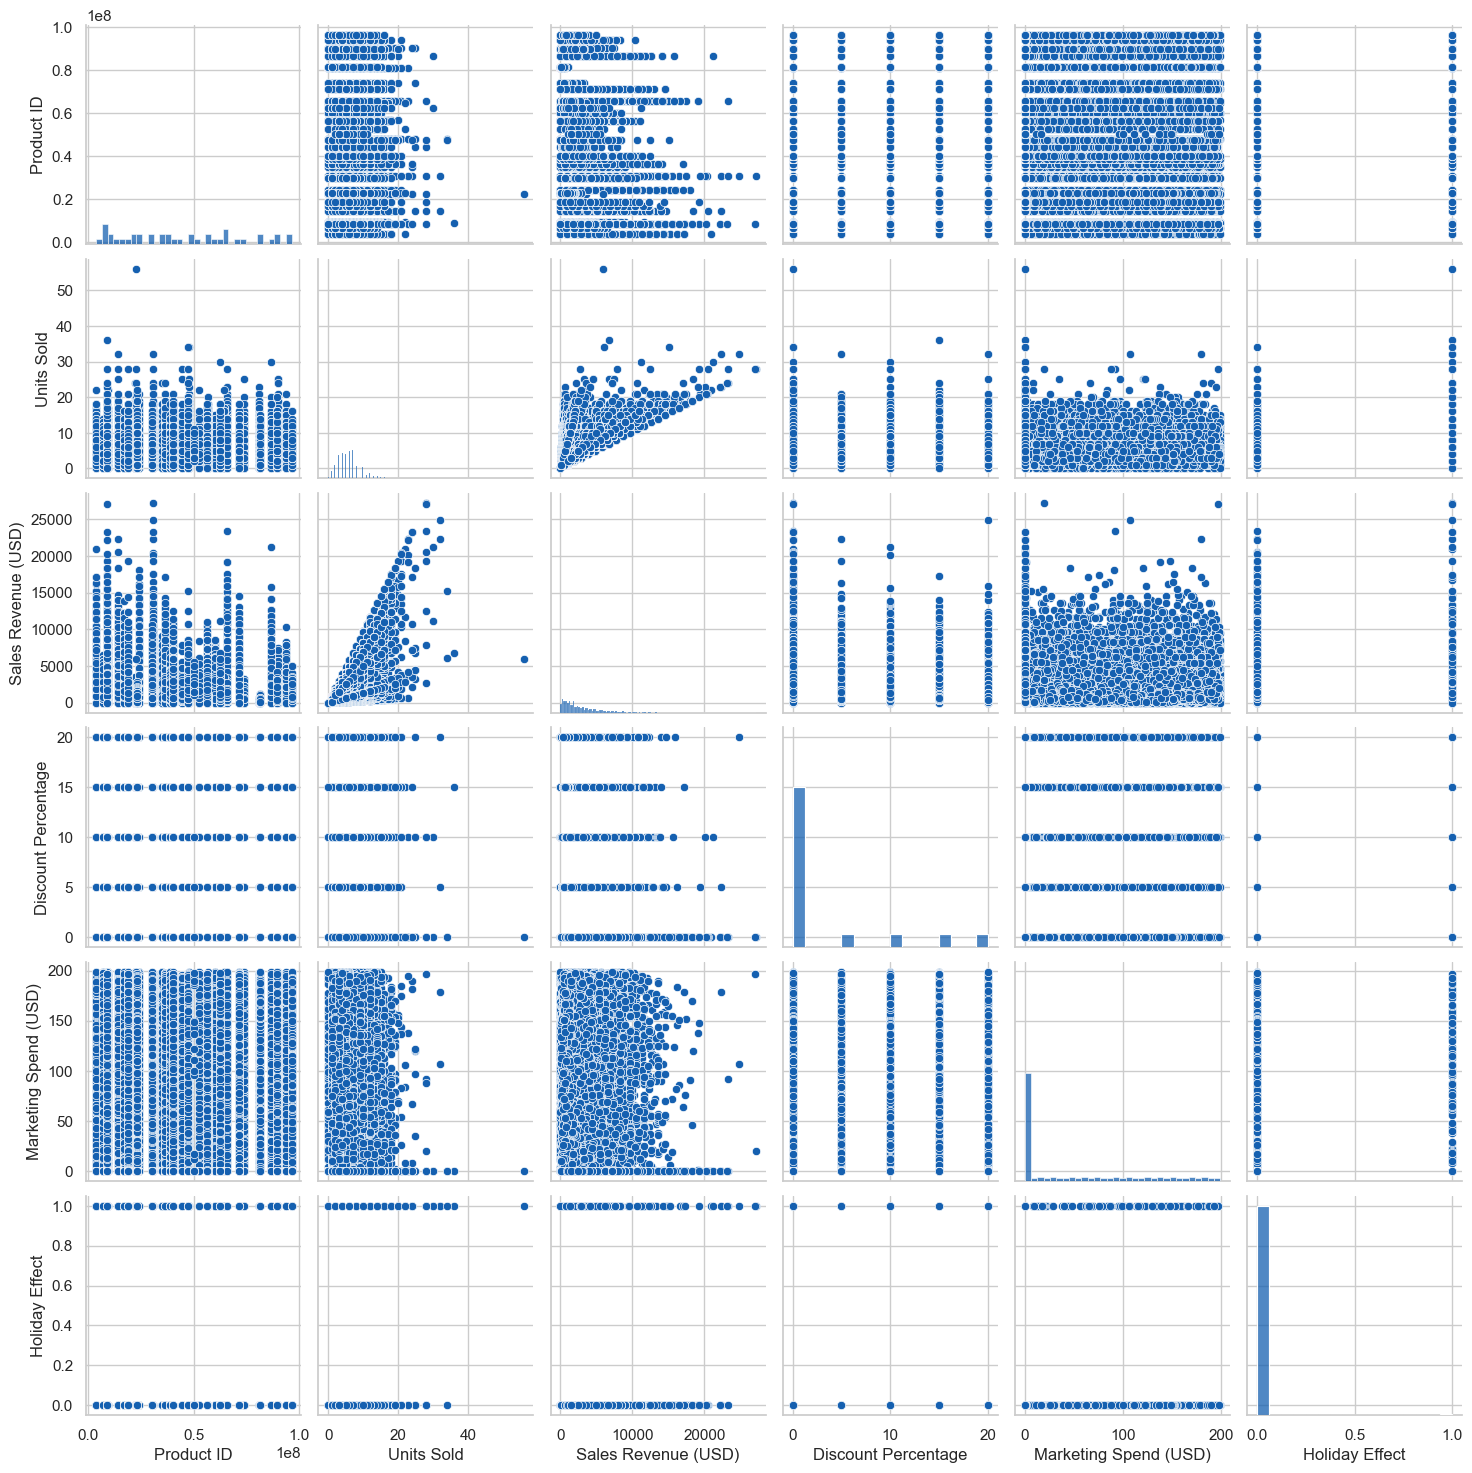

In [60]:
sns.pairplot(sales)
plt.show()

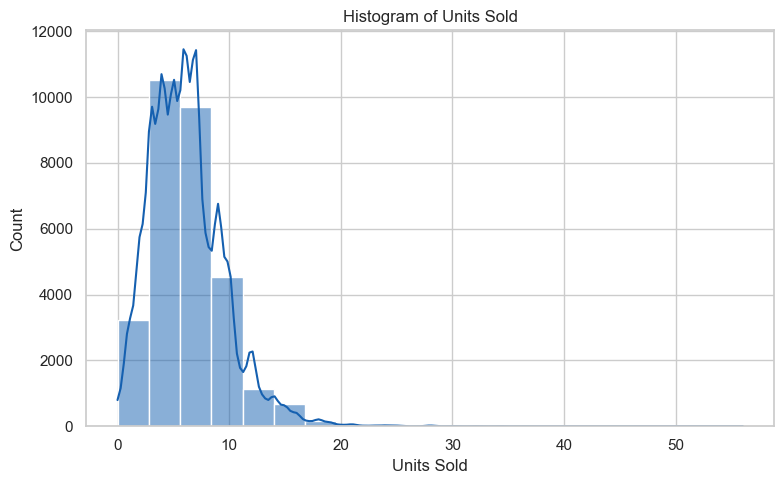

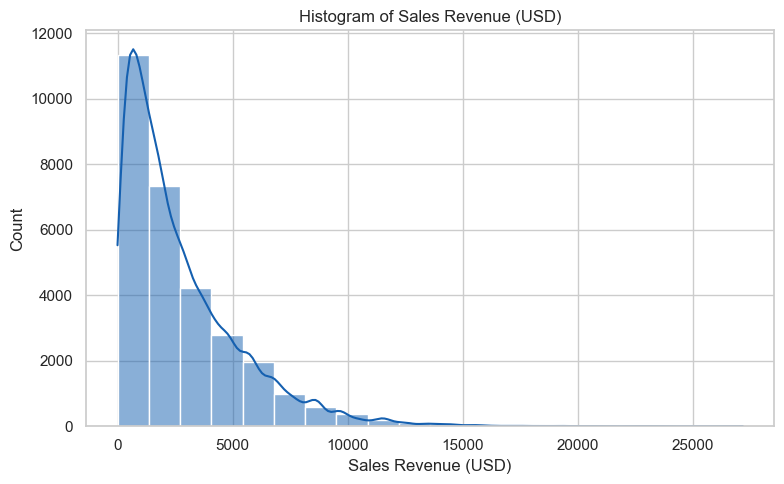

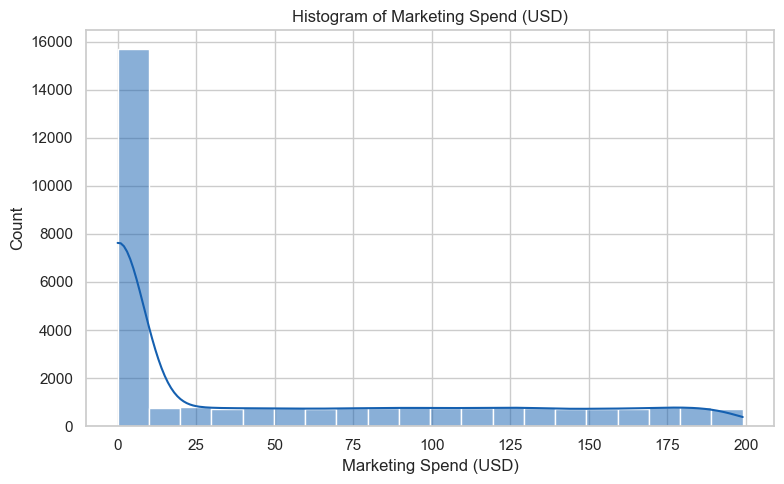

In [61]:
numericalCols = ['Units Sold', 'Sales Revenue (USD)','Marketing Spend (USD)']

for column in numericalCols:
   
    plt.figure(figsize=(8, 5))
    sns.histplot(data=sales, x=column, kde=True, bins=20)
    plt.title(f'Histogram of {column}')
    
    plt.tight_layout()
    plt.show()

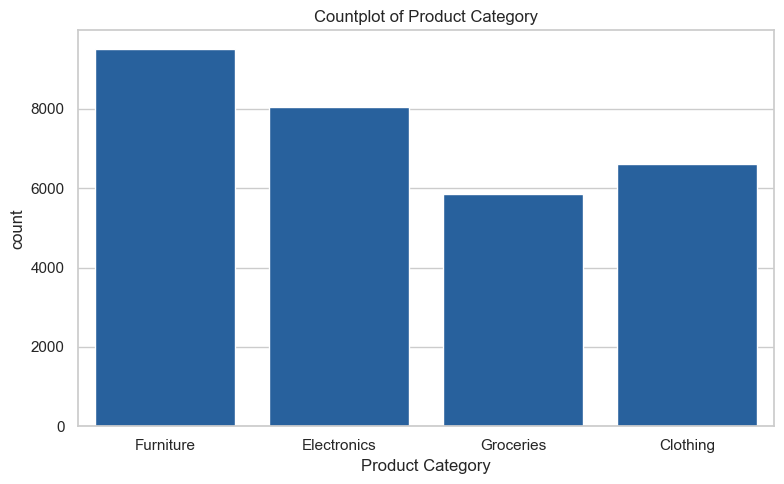

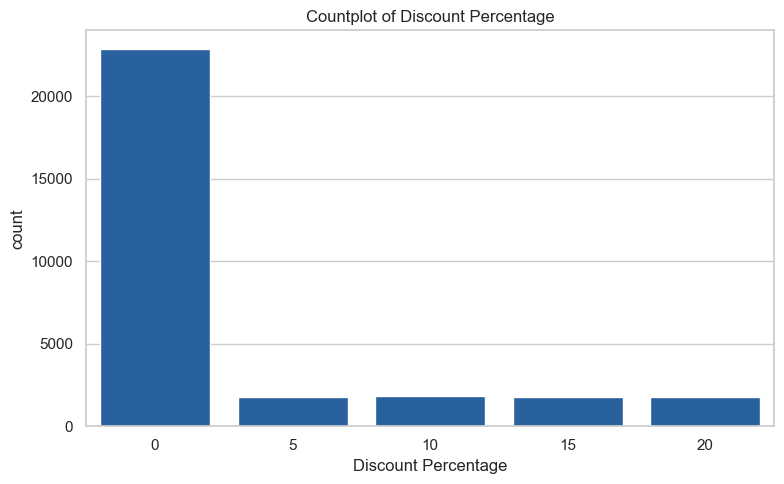

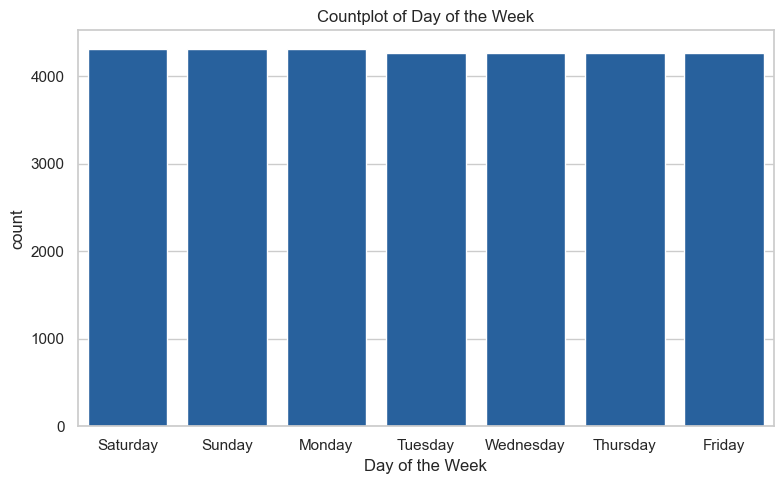

In [62]:
categoricalCols = ['Product Category', 'Discount Percentage', 'Day of the Week']

for column in categoricalCols:
   
    plt.figure(figsize=(8, 5))
    sns.countplot(data=sales, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()

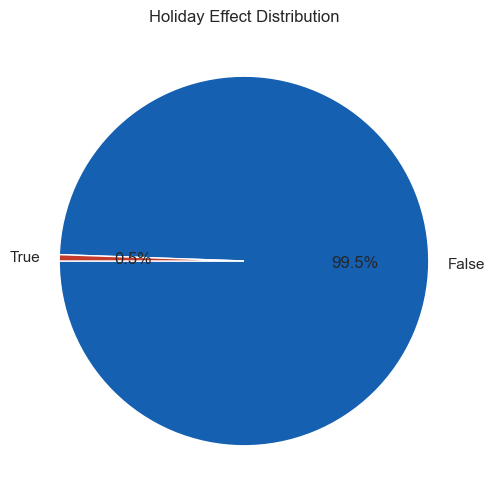

In [63]:
categories = [False, True]
counts = sales['Holiday Effect'].value_counts().tolist()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=180, colors=custom_palette)
plt.title('Holiday Effect Distribution')
plt.show()

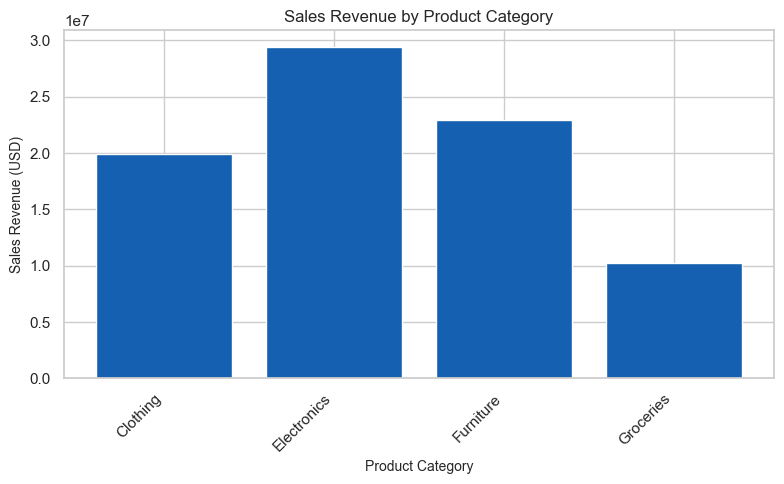

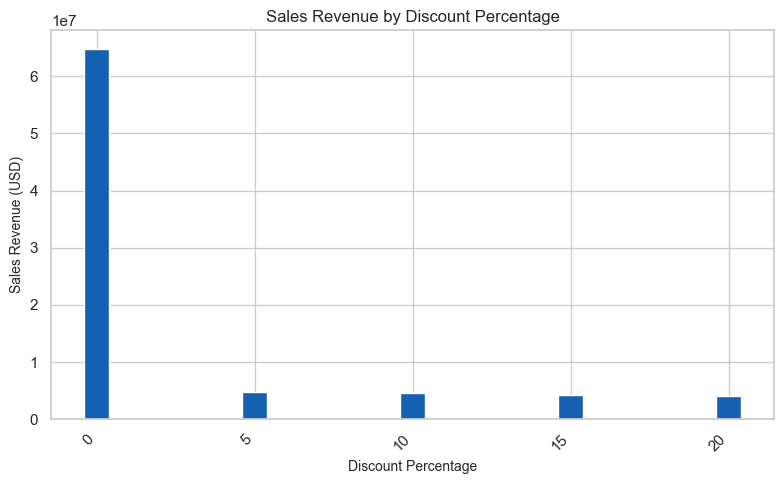

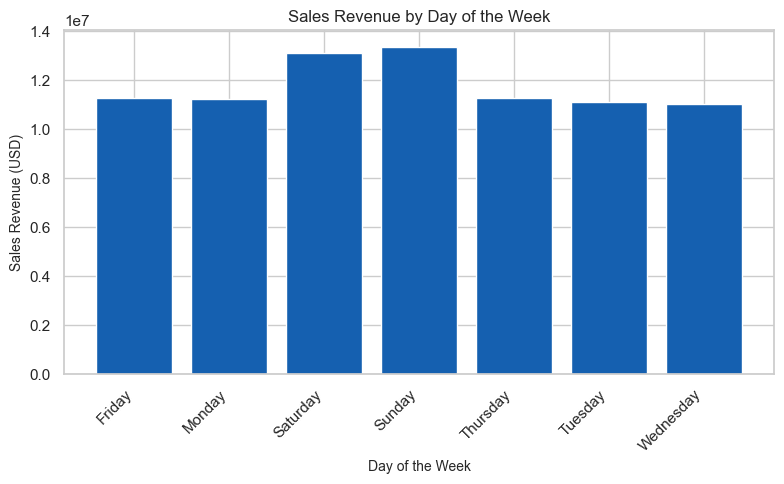

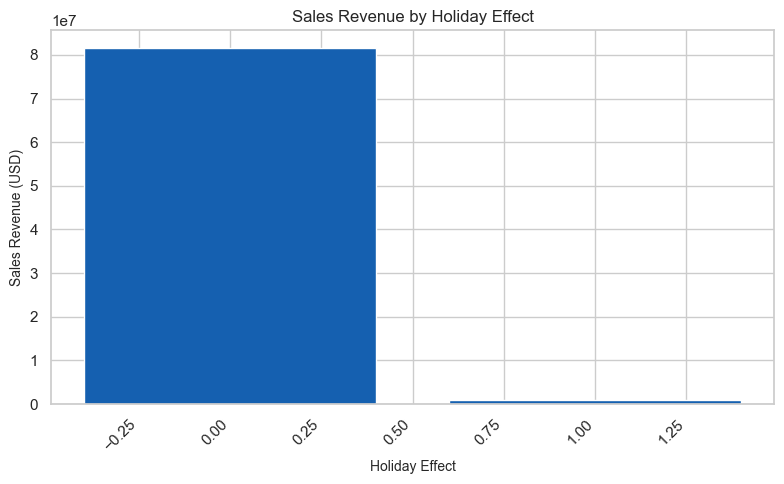

In [64]:
columns = ['Product Category', 'Discount Percentage', 'Day of the Week', 'Holiday Effect']

for column in columns:
    grouped_data = sales.groupby(column)['Sales Revenue (USD)'].sum().reset_index()
    
    plt.figure(figsize=(8, 5))
    
    plt.bar(grouped_data[column], grouped_data['Sales Revenue (USD)'])
    
    plt.title(f'Sales Revenue by {column}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel('Sales Revenue (USD)', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [65]:
numeric_columns = sales.select_dtypes(include=[np.int64, np.float64]).columns.tolist()

In [66]:
def detect_outliers(sales, column):
    Q1 = sales[column].quantile(0.25)
    Q3 = sales[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales[(sales[column] < lower_bound) | (sales[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

In [67]:
outlier_summary = {}
for col in numeric_columns:
    outliers, lower_bound, upper_bound = detect_outliers(sales, col)
    outlier_summary[col] = {
        'Outliers': outliers,
        'Count': len(outliers),
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }

In [68]:
print("Ringkasan Outlier untuk Setiap Kolom Numerik:")
for col, summary in outlier_summary.items():
    print(f"\nKolom: {col}")
    print(f"Jumlah Outlier: {summary['Count']}")
    print(f"Batas Bawah: {summary['Lower Bound']:.2f}")
    print(f"Batas Atas: {summary['Upper Bound']:.2f}")
    if summary['Count'] > 0:
        print("Contoh Outlier:")
        print(summary['Outliers'].head().to_string(index=True))
    else:
        print("Tidak ada outlier.")

Ringkasan Outlier untuk Setiap Kolom Numerik:

Kolom: Product ID
Jumlah Outlier: 0
Batas Bawah: -42675284.50
Batas Atas: 130554807.50
Tidak ada outlier.

Kolom: Units Sold
Jumlah Outlier: 594
Batas Bawah: -2.00
Batas Atas: 14.00
Contoh Outlier:
316    15
326    15
351    15
358    22
494    15

Kolom: Sales Revenue (USD)
Jumlah Outlier: 1305
Batas Bawah: -3589.40
Batas Atas: 8335.91
Contoh Outlier:
358     8377.38
738     9512.10
745     8560.89
760    11985.25
763    10463.31

Kolom: Discount Percentage
Jumlah Outlier: 7154
Batas Bawah: 0.00
Batas Atas: 0.00
Contoh Outlier:
0     20
12    15
14    15
20    20
23    10

Kolom: Marketing Spend (USD)
Jumlah Outlier: 0
Batas Bawah: -150.00
Batas Atas: 250.00
Tidak ada outlier.


In [69]:
from scipy.stats import skew

skewness = sales[numeric_columns].skew()
print(f"Skewness: {skewness}")

Skewness: Product ID               0.260714
Units Sold               1.171856
Sales Revenue (USD)      1.788606
Discount Percentage      1.861774
Marketing Spend (USD)    0.926757
dtype: float64


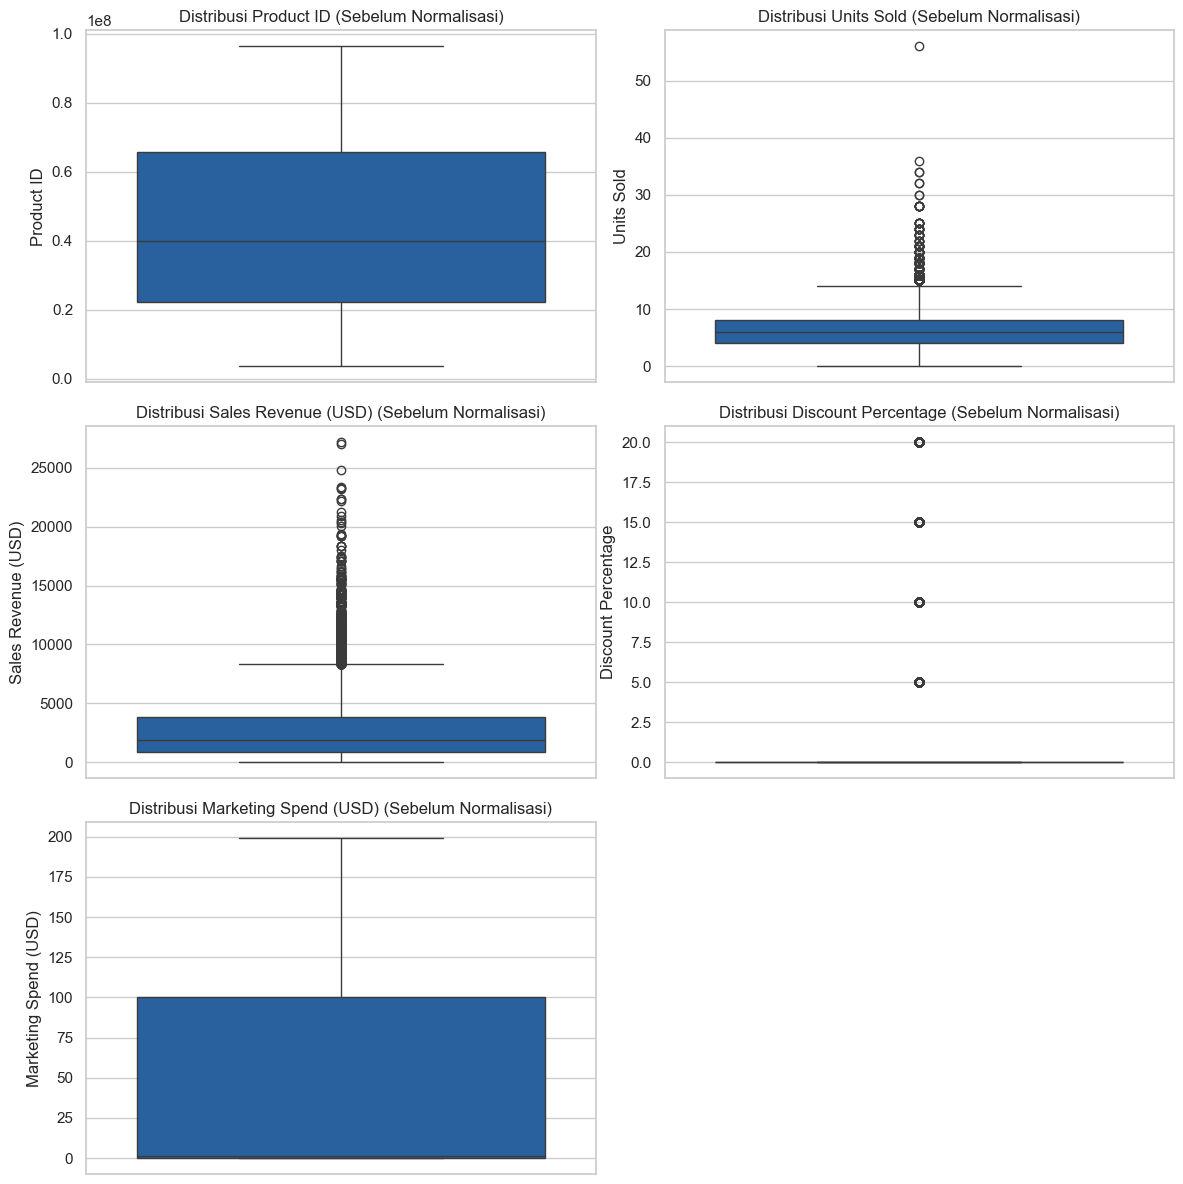

In [70]:
n_cols = len(numeric_columns)
n_rows = int(np.ceil(n_cols / 2))  

plt.figure(figsize=(12, 4 * n_rows))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, 2, i)
    sns.boxplot(y=sales[col])
    plt.title(f'Distribusi {col} (Sebelum Normalisasi)')

plt.tight_layout()
plt.show()

In [71]:
def replaceOutlier(sales, column):
    Q1 = sales[column].quantile(0.25)
    Q3 = sales[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median = sales[column].median()

    sales[column] = np.where((sales[column] < lower_bound) | (sales[column] > upper_bound), median, sales[column])

In [72]:
columns_with_outliers = ['Units Sold', 'Sales Revenue (USD)', 'Discount Percentage']

for col in columns_with_outliers:
    replaceOutlier(sales, col)

In [73]:
scaler = RobustScaler()
sales[numeric_columns] = scaler.fit_transform(sales[numeric_columns])  

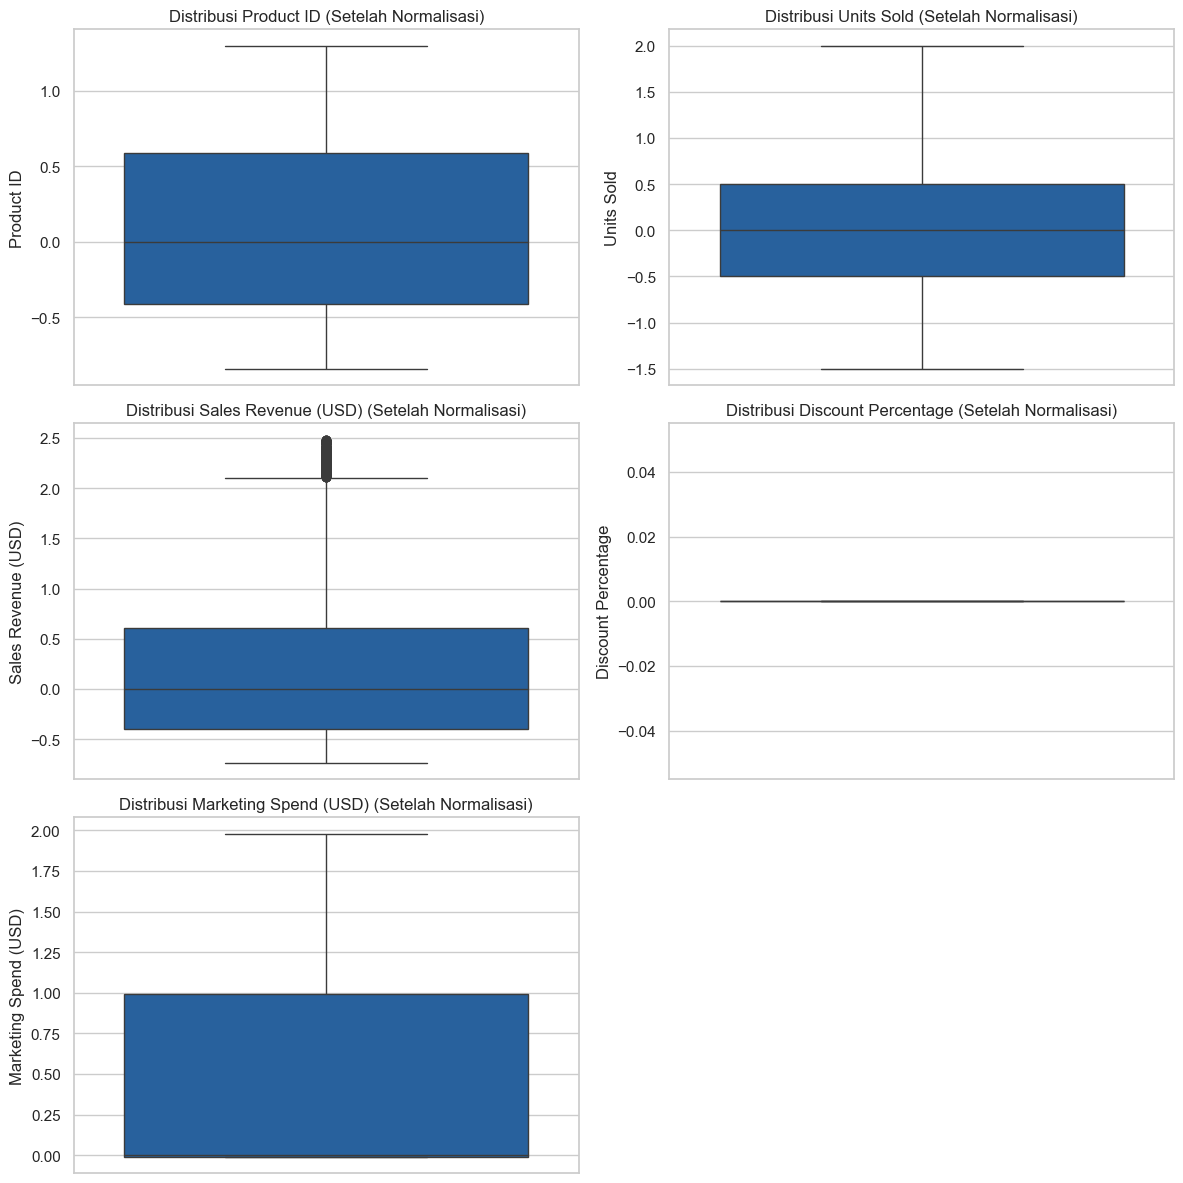

In [74]:
n_cols = len(numeric_columns)
n_rows = int(np.ceil(n_cols / 2))  

plt.figure(figsize=(12, 4 * n_rows))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, 2, i)
    sns.boxplot(y=sales[col])
    plt.title(f'Distribusi {col} (Setelah Normalisasi)')

plt.tight_layout()
plt.show()

In [75]:
geolocator = Nominatim(user_agent="retail_sales_clustering")

In [76]:
def get_coordinates(location):
    try:
        loc = geolocator.geocode(location)
        if loc:
            return loc.latitude, loc.longitude
        else:
            return np.nan, np.nan
    except:
        return np.nan, np.nan

In [77]:
location_performance = sales.groupby('Store Location').agg({
    'Sales Revenue (USD)': 'sum',
    'Units Sold': 'sum'
}).reset_index()

In [78]:
location_performance['Latitude'] = location_performance['Store Location'].apply(lambda x: get_coordinates(x)[0])
location_performance['Longitude'] = location_performance['Store Location'].apply(lambda x: get_coordinates(x)[1])

In [79]:
location_performance = location_performance.dropna(subset=['Latitude', 'Longitude'])

In [80]:
geometry = [Point(xy) for xy in zip(location_performance['Longitude'], location_performance['Latitude'])]
gdf = gpd.GeoDataFrame(location_performance, geometry=geometry, crs="EPSG:4326")

In [81]:
sales_min = gdf['Sales Revenue (USD)'].min()
sales_max = gdf['Sales Revenue (USD)'].max()
sales_range = sales_max - sales_min
gdf['Normalized Sales'] = (gdf['Sales Revenue (USD)'] - sales_min) / sales_range if sales_range != 0 else 0

In [82]:
m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB positron')

In [83]:
marker_cluster = MarkerCluster().add_to(m)

In [84]:
cmap = plt.cm.get_cmap('viridis')

for i, row in gdf.iterrows():
    color = mcolors.rgb2hex(cmap(row['Normalized Sales']))
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=2,  
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['Store Location']}</b><br>"
            f"Sales Revenue: ${row['Sales Revenue (USD)']:.2f}<br>"
            f"Units Sold: {row['Units Sold']}",
            max_width=300
        )
    ).add_to(marker_cluster)

In [85]:
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; padding: 10px; background-color: white; border: 2px solid grey; border-radius: 5px;">
    <b>Sales Revenue (USD)</b><br>
    <i style="background: #440154; width: 18px; height: 18px; float: left; margin-right: 8px;"></i> Low<br>
    <i style="background: #21908C; width: 18px; height: 18px; float: left; margin-right: 8px;"></i> Medium<br>
    <i style="background: #FDE725; width: 18px; height: 18px; float: left; margin-right: 8px;"></i> High
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save('sales_performance_map.html')
display(m)

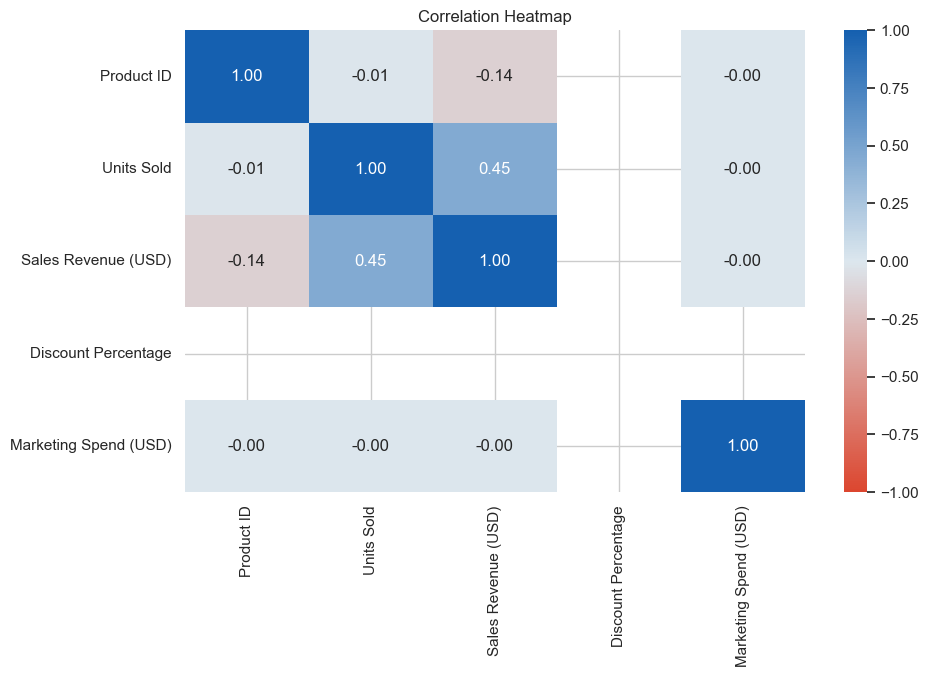

In [86]:
colors = ["#DC462F", "#DCE7EE", "#1560B0"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

numericData = sales.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(numericData.corr(), annot=True, cmap=cmap, center=0, vmin=-1, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [87]:
X = sales[['Product ID','Store Location', 'Product Category', 'Units Sold', 'Day of the Week',
        'Discount Percentage', 'Marketing Spend (USD)', 'Holiday Effect']]
y = sales['Sales Revenue (USD)']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
categorical_cols = ['Product ID', 'Store Location', 'Product Category', 'Day of the Week']
numerical_cols = ['Units Sold', 'Discount Percentage', 'Marketing Spend (USD)'] 
boolean_cols = ['Holiday Effect']

In [90]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('bool', 'passthrough', boolean_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [91]:
results = []

# Function to evaluate models and store results for visualization
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_test = pipeline.predict(X_test)
    
    # Calculate metrics: R² and RMSE
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Print results
    print(f"{model_name} Model:")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}\n")
    
    # Append results to the list for visualization
    results.append({'Model': model_name, 'R²': test_r2, 'RMSE': test_rmse})

In [92]:
# Define models to evaluate
models = {
    'SGD Regressor': SGDRegressor(),
    'ElasticNet': ElasticNet(),
    'Bagging': BaggingRegressor()
}

In [93]:
# Iterate over the models to evaluate each
for model_name, model in models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
 
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

SGD Regressor Model:
Test R²: 0.6593
Test RMSE: 0.4316

ElasticNet Model:
Test R²: -0.0000
Test RMSE: 0.7395

Bagging Model:
Test R²: 0.8997
Test RMSE: 0.2342



In [94]:
results_df

,Model,R²,RMSE
0,SGD Regressor,0.659279,0.431641
1,ElasticNet,-0.000002,0.739475
2,Bagging,0.899656,0.234244


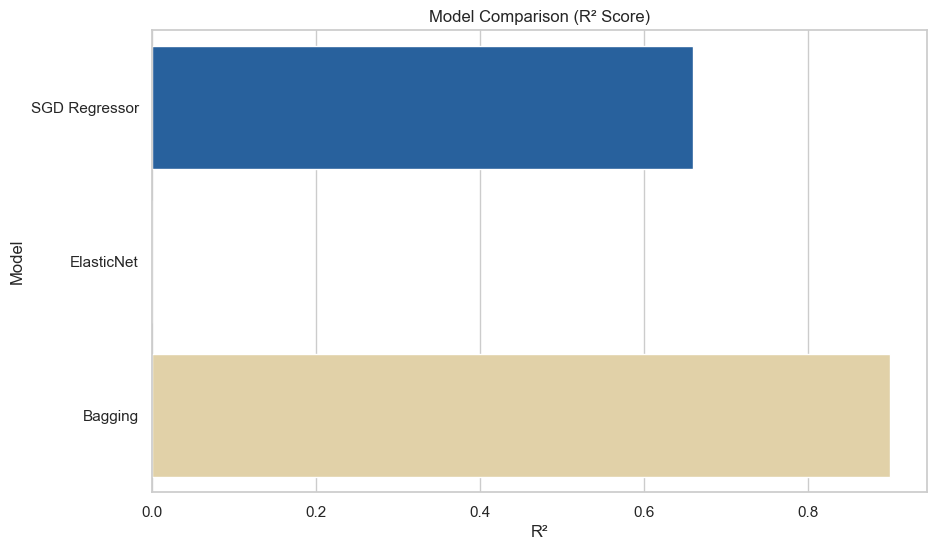

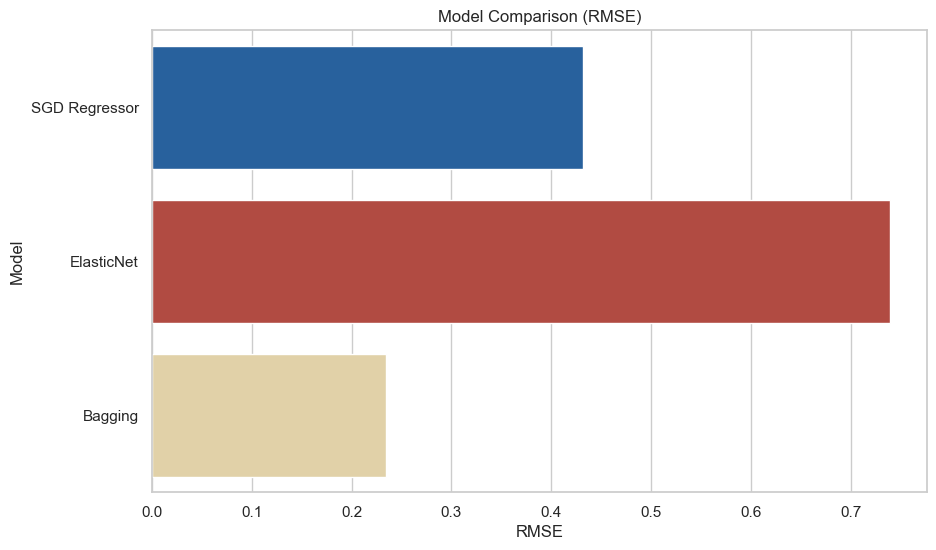

In [95]:
# Plot R² comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='R²', y='Model', data=results_df, palette=custom_palette)
plt.title('Model Comparison (R² Score)')
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette=custom_palette)
plt.title('Model Comparison (RMSE)')
plt.show()